# Concatenated Topological CSS Codes - Visualization & Coordinate Testing

This notebook provides systematic testing for `ConcatenatedTopologicalCSSCode`:
1. **Setup & Imports** - Load dependencies and configure cache clearing
2. **Code Construction Tests** - Test multiple outer/inner code combinations
3. **Coordinate Metadata** - Validate block arrangement and scaling
4. **Visualization** - Plot concatenated code geometry
5. **QUBIT_COORDS Generation** - Verify Stim circuit coordinates

Reference implementation from decoder_smoke_test.ipynb patterns.

In [64]:
"""Setup and Imports - Concatenated Codes Testing"""
import sys
import importlib
import signal
import time
import numpy as np
import matplotlib.pyplot as plt

# Clear module cache for fresh testing
modules_to_clear = [m for m in sys.modules if 'qectostim' in m]
for m in modules_to_clear:
    del sys.modules[m]

# Imports
from qectostim.codes.small.four_two_two import FourQubit422Code
from qectostim.codes.small.steane_713 import SteanCode713
from qectostim.codes.surface.rotated_surface import RotatedSurfaceCode
from qectostim.codes.composite.concatenated import ConcatenatedTopologicalCSSCode
from qectostim.experiments.memory import CSSMemoryExperiment
from qectostim.noise.models import CircuitDepolarizingNoise, NoiseModel

print("✓ All imports successful")
print(f"  ConcatenatedTopologicalCSSCode: {ConcatenatedTopologicalCSSCode}")
print(f"  Inner codes: FourQubit422Code, SteanCode713")
print(f"  Outer codes: RotatedSurfaceCode")

✓ All imports successful
  ConcatenatedTopologicalCSSCode: <class 'qectostim.codes.composite.concatenated.ConcatenatedTopologicalCSSCode'>
  Inner codes: FourQubit422Code, SteanCode713
  Outer codes: RotatedSurfaceCode


In [65]:
"""Test 1: Code Construction with Multiple Combinations"""
results = []

# Test different outer/inner combinations
test_cases = [
    ("RotatedSurface(d=3) + 422", RotatedSurfaceCode(distance=3), FourQubit422Code()),
    ("RotatedSurface(d=5) + 422", RotatedSurfaceCode(distance=5), FourQubit422Code()),
    ("RotatedSurface(d=3) + Steane", RotatedSurfaceCode(distance=3), SteanCode713()),
]

print("Code Construction Tests:")
print("=" * 70)
for name, outer, inner in test_cases:
    try:
        start = time.time()
        concat = ConcatenatedTopologicalCSSCode(outer, inner, scale=3)
        elapsed = time.time() - start
        
        # Validate basic properties
        n = concat.n
        k = concat.k
        n_x = concat.hx.shape[0]  # Number of X stabilizers
        n_z = concat.hz.shape[0]  # Number of Z stabilizers
        
        # Check parameters match expectation: n = n_outer * n_inner
        expected_n = outer.n * inner.n
        status = "✓" if n == expected_n else f"✗ (expected n={expected_n})"
        
        results.append((name, status, n, k, n_x, n_z, elapsed))
        print(f"{status} {name}")
        print(f"    n={n}, k={k}, x_stabs={n_x}, z_stabs={n_z}, time={elapsed:.3f}s")
    except Exception as e:
        results.append((name, f"✗ {type(e).__name__}", 0, 0, 0, 0, 0))
        print(f"✗ {name}: {type(e).__name__}: {e}")

passed = sum(1 for r in results if r[1].startswith("✓"))
print(f"\nConstruction: {passed}/{len(results)} passed")

Code Construction Tests:
✓ RotatedSurface(d=3) + 422
    n=36, k=10, x_stabs=13, z_stabs=13, time=0.000s
✓ RotatedSurface(d=5) + 422
    n=100, k=26, x_stabs=37, z_stabs=37, time=0.001s
✓ RotatedSurface(d=3) + Steane
    n=63, k=1, x_stabs=31, z_stabs=31, time=0.001s

Construction: 3/3 passed


In [66]:
"""Test 2: Coordinate Metadata and Block Arrangement"""
print("Coordinate Metadata Tests:")
print("=" * 70)

# Create a simple concatenated code for inspection
inner = RotatedSurfaceCode(distance=3)
outer = FourQubit422Code()
concat = ConcatenatedTopologicalCSSCode(outer, inner, scale=20)

# Get coordinate metadata from _metadata
meta = getattr(concat, '_metadata', {})

print(f"Outer code: {outer.name}, n={outer.n}")
print(f"Inner code: {inner.name}, n={inner.n}")
print(f"Concatenated: n={concat.n} (expected {outer.n * inner.n})")
print()

# Analyze block structure
data_coords = concat.qubit_coords()
x_stab_coords = meta.get('x_stab_coords', [])
z_stab_coords = meta.get('z_stab_coords', [])

print(f"Data qubits: {len(data_coords)}")
print(f"X stabilizer coords: {len(x_stab_coords)}")
print(f"Z stabilizer coords: {len(z_stab_coords)}")

# Check coordinate ranges and spacing
if data_coords:
    x_vals = [c[0] for c in data_coords]
    y_vals = [c[1] for c in data_coords]
    print(f"\nData qubit coordinate ranges:")
    print(f"  X: [{min(x_vals):.2f}, {max(x_vals):.2f}]")
    print(f"  Y: [{min(y_vals):.2f}, {max(y_vals):.2f}]")
    
# Verify expected counts - use hx.shape[0] instead of x_stabilizers method
expected_data = outer.n * inner.n
data_count_ok = len(data_coords) == expected_data

print(f"\nExpected vs Actual:")
print(f"  Data: expected {expected_data}, got {len(data_coords)} {'✓' if data_count_ok else '✗'}")
print(f"  X stab coords: {len(x_stab_coords)} (from metadata)")
print(f"  Z stab coords: {len(z_stab_coords)} (from metadata)")

Coordinate Metadata Tests:
Outer code: FourQubit422Code, n=4
Inner code: RotatedSurfaceCode, n=9
Concatenated: n=36 (expected 36)

Data qubits: 36
X stabilizer coords: 17
Z stabilizer coords: 17

Data qubit coordinate ranges:
  X: [-12.00, 12.00]
  Y: [-12.00, 12.00]

Expected vs Actual:
  Data: expected 36, got 36 ✓
  X stab coords: 17 (from metadata)
  Z stab coords: 17 (from metadata)


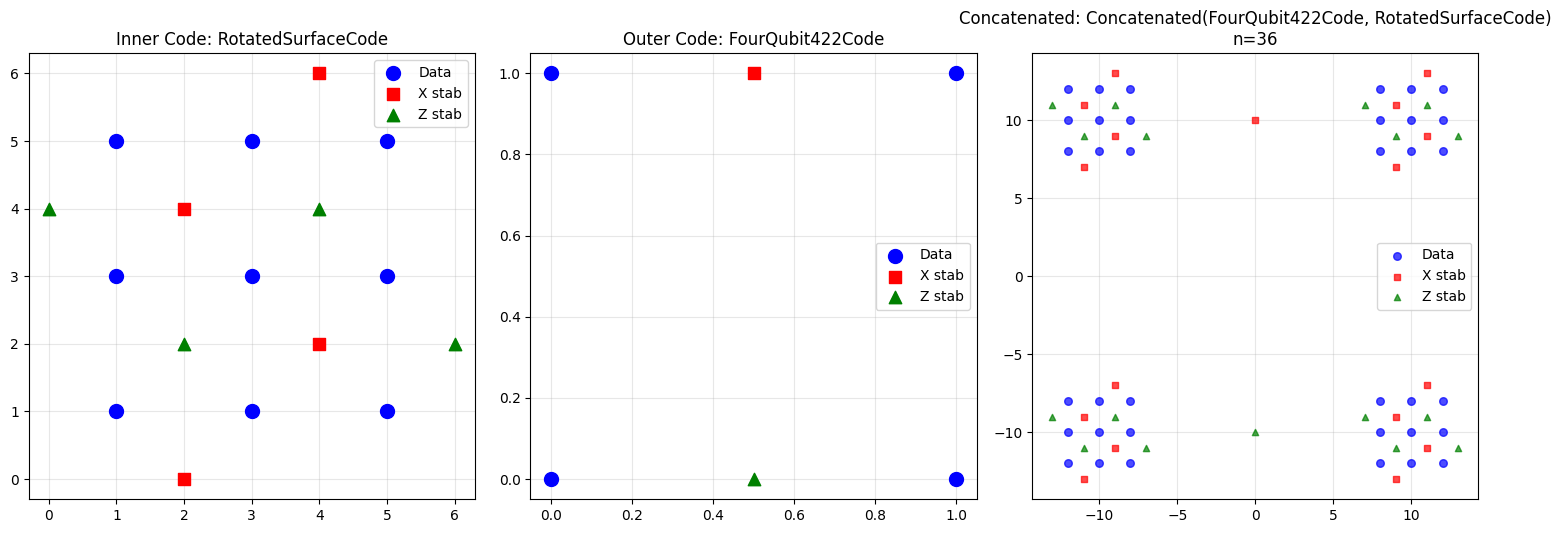

✓ Visualization complete


In [67]:
"""Test 3: Visualization of Concatenated Code Geometry"""
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Inner code geometry (422)
ax1 = axes[0]
inner_meta = getattr(inner, '_metadata', {})
inner_data = np.array(inner.qubit_coords()) if hasattr(inner, 'qubit_coords') else np.array([[0,0]])
inner_x_stab = inner_meta.get('x_stab_coords', [])
inner_z_stab = inner_meta.get('z_stab_coords', [])

ax1.scatter(inner_data[:, 0], inner_data[:, 1], c='blue', s=100, label='Data', zorder=5)
if inner_x_stab:
    inner_x = np.array(inner_x_stab)
    ax1.scatter(inner_x[:, 0], inner_x[:, 1], c='red', s=80, marker='s', label='X stab', zorder=4)
if inner_z_stab:
    inner_z = np.array(inner_z_stab)
    ax1.scatter(inner_z[:, 0], inner_z[:, 1], c='green', s=80, marker='^', label='Z stab', zorder=4)
ax1.set_title(f'Inner Code: {inner.name}')
ax1.legend()
ax1.set_aspect('equal')
ax1.grid(True, alpha=0.3)

# Plot 2: Outer code geometry (Surface d=3)
ax2 = axes[1]
outer_meta = getattr(outer, '_metadata', {})
outer_data = np.array(outer.qubit_coords()) if hasattr(outer, 'qubit_coords') else np.array([[0,0]])
outer_x_stab = outer_meta.get('x_stab_coords', [])
outer_z_stab = outer_meta.get('z_stab_coords', [])

ax2.scatter(outer_data[:, 0], outer_data[:, 1], c='blue', s=100, label='Data', zorder=5)
if outer_x_stab:
    outer_x = np.array(outer_x_stab)
    ax2.scatter(outer_x[:, 0], outer_x[:, 1], c='red', s=80, marker='s', label='X stab', zorder=4)
if outer_z_stab:
    outer_z = np.array(outer_z_stab)
    ax2.scatter(outer_z[:, 0], outer_z[:, 1], c='green', s=80, marker='^', label='Z stab', zorder=4)
ax2.set_title(f'Outer Code: {outer.name}')
ax2.legend()
ax2.set_aspect('equal')
ax2.grid(True, alpha=0.3)

# Plot 3: Concatenated code geometry
ax3 = axes[2]
concat_data = np.array(data_coords) if data_coords else np.array([[0,0]])
concat_x_stab = np.array(x_stab_coords) if x_stab_coords else None
concat_z_stab = np.array(z_stab_coords) if z_stab_coords else None

ax3.scatter(concat_data[:, 0], concat_data[:, 1], c='blue', s=30, label='Data', zorder=5, alpha=0.7)
if concat_x_stab is not None and len(concat_x_stab) > 0:
    ax3.scatter(concat_x_stab[:, 0], concat_x_stab[:, 1], c='red', s=20, marker='s', label='X stab', zorder=4, alpha=0.7)
if concat_z_stab is not None and len(concat_z_stab) > 0:
    ax3.scatter(concat_z_stab[:, 0], concat_z_stab[:, 1], c='green', s=20, marker='^', label='Z stab', zorder=4, alpha=0.7)
ax3.set_title(f'Concatenated: {concat.name}\nn={concat.n}')
ax3.legend()
ax3.set_aspect('equal')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print("✓ Visualization complete")

In [68]:
"""Test 4: Scale Parameter Effects"""
print("Scale Parameter Tests:")
print("=" * 70)

scale_tests = []
for scale in [1, 2, 3, 5]:
    try:
        outer_test = RotatedSurfaceCode(distance=3)
        inner_test = FourQubit422Code()
        concat_test = ConcatenatedTopologicalCSSCode(outer_test, inner_test, scale=scale)
        
        data_test = concat_test.qubit_coords()
        
        if len(data_test) > 0:
            x_vals = [c[0] for c in data_test]
            y_vals = [c[1] for c in data_test]
            x_span = max(x_vals) - min(x_vals)
            y_span = max(y_vals) - min(y_vals)
            scale_tests.append((scale, len(data_test), x_span, y_span, "✓"))
            print(f"✓ scale={scale}: {len(data_test)} data qubits, span=({x_span:.2f}, {y_span:.2f})")
        else:
            scale_tests.append((scale, 0, 0, 0, "✗ no coords"))
            print(f"✗ scale={scale}: No coordinate data")
    except Exception as e:
        scale_tests.append((scale, 0, 0, 0, f"✗ {type(e).__name__}"))
        print(f"✗ scale={scale}: {type(e).__name__}: {e}")

# Verify scaling is proportional
if len(scale_tests) >= 2:
    print("\nScale proportionality check:")
    for i in range(1, len(scale_tests)):
        if scale_tests[i-1][4] == "✓" and scale_tests[i][4] == "✓":
            scale_ratio = scale_tests[i][0] / scale_tests[i-1][0]
            span_ratio_x = scale_tests[i][2] / scale_tests[i-1][2] if scale_tests[i-1][2] > 0 else 0
            span_ratio_y = scale_tests[i][3] / scale_tests[i-1][3] if scale_tests[i-1][3] > 0 else 0
            print(f"  scale {scale_tests[i-1][0]}→{scale_tests[i][0]}: ratio={scale_ratio:.2f}, x_span_ratio={span_ratio_x:.2f}, y_span_ratio={span_ratio_y:.2f}")

Scale Parameter Tests:
✓ scale=1: 36 data qubits, span=(5.00, 5.00)
✓ scale=2: 36 data qubits, span=(9.00, 9.00)
✓ scale=3: 36 data qubits, span=(13.00, 13.00)
✓ scale=5: 36 data qubits, span=(21.00, 21.00)

Scale proportionality check:
  scale 1→2: ratio=2.00, x_span_ratio=1.80, y_span_ratio=1.80
  scale 2→3: ratio=1.50, x_span_ratio=1.44, y_span_ratio=1.44
  scale 3→5: ratio=1.67, x_span_ratio=1.62, y_span_ratio=1.62


In [73]:
"""Test 5: QUBIT_COORDS Generation in Stim Circuit"""
print("QUBIT_COORDS in Stim Circuit:")
print("=" * 70)

# Build a memory experiment and check QUBIT_COORDS
outer_exp = RotatedSurfaceCode(distance=3)
inner_exp = FourQubit422Code()
concat_exp = ConcatenatedTopologicalCSSCode(outer_exp, inner_exp, scale=3)

noise = CircuitDepolarizingNoise(p1=0.001, p2=0.001)
exp = CSSMemoryExperiment(code=concat_exp, noise_model=noise, rounds=1)

# Generate Stim circuit
circuit = exp.to_stim()
circuit_str = str(circuit)

# Extract QUBIT_COORDS lines
qubit_coords_lines = [line for line in circuit_str.split('\n') if 'QUBIT_COORDS' in line]
print(f"Found {len(qubit_coords_lines)} QUBIT_COORDS instructions")

if qubit_coords_lines:
    print(f"\nFirst 5 QUBIT_COORDS:")
    for line in qubit_coords_lines[:5]:
        print(f"  {line.strip()}")
    if len(qubit_coords_lines) > 5:
        print(f"  ... and {len(qubit_coords_lines) - 5} more")
    
    # Verify coordinate count matches expected qubits
    expected_qubits = concat_exp.n + concat_exp.hx.shape[0] + concat_exp.hz.shape[0]
    print(f"\nExpected total qubits (data + ancilla): ~{expected_qubits}")
    print(f"QUBIT_COORDS found: {len(qubit_coords_lines)}")
    
    if len(qubit_coords_lines) >= concat_exp.n:
        print("✓ Sufficient QUBIT_COORDS generated")
    else:
        print("⚠ Fewer QUBIT_COORDS than expected")
else:
    print("⚠ No QUBIT_COORDS found in circuit")

print(circuit_str)

QUBIT_COORDS in Stim Circuit:
Found 62 QUBIT_COORDS instructions

First 5 QUBIT_COORDS:
  QUBIT_COORDS(-6.5, -6.5) 0
  QUBIT_COORDS(-5.5, -6.5) 1
  QUBIT_COORDS(-5.5, -5.5) 2
  QUBIT_COORDS(-6.5, -5.5) 3
  QUBIT_COORDS(-0.5, -6.5) 4
  ... and 57 more

Expected total qubits (data + ancilla): ~62
QUBIT_COORDS found: 62
✓ Sufficient QUBIT_COORDS generated
QUBIT_COORDS(-6.5, -6.5) 0
QUBIT_COORDS(-5.5, -6.5) 1
QUBIT_COORDS(-5.5, -5.5) 2
QUBIT_COORDS(-6.5, -5.5) 3
QUBIT_COORDS(-0.5, -6.5) 4
QUBIT_COORDS(0.5, -6.5) 5
QUBIT_COORDS(0.5, -5.5) 6
QUBIT_COORDS(-0.5, -5.5) 7
QUBIT_COORDS(5.5, -6.5) 8
QUBIT_COORDS(6.5, -6.5) 9
QUBIT_COORDS(6.5, -5.5) 10
QUBIT_COORDS(5.5, -5.5) 11
QUBIT_COORDS(-6.5, -0.5) 12
QUBIT_COORDS(-5.5, -0.5) 13
QUBIT_COORDS(-5.5, 0.5) 14
QUBIT_COORDS(-6.5, 0.5) 15
QUBIT_COORDS(-0.5, -0.5) 16
QUBIT_COORDS(0.5, -0.5) 17
QUBIT_COORDS(0.5, 0.5) 18
QUBIT_COORDS(-0.5, 0.5) 19
QUBIT_COORDS(5.5, -0.5) 20
QUBIT_COORDS(6.5, -0.5) 21
QUBIT_COORDS(6.5, 0.5) 22
QUBIT_COORDS(5.5, 0.5) 23
Q

In [70]:
circuit.to_crumble_url()

'https://algassert.com/crumble#circuit=Q(-6.5,-6.5)0;Q(-5.5,-6.5)1;Q(-5.5,-5.5)2;Q(-6.5,-5.5)3;Q(-0.5,-6.5)4;Q(0.5,-6.5)5;Q(0.5,-5.5)6;Q(-0.5,-5.5)7;Q(5.5,-6.5)8;Q(6.5,-6.5)9;Q(6.5,-5.5)10;Q(5.5,-5.5)11;Q(-6.5,-0.5)12;Q(-5.5,-0.5)13;Q(-5.5,0.5)14;Q(-6.5,0.5)15;Q(-0.5,-0.5)16;Q(0.5,-0.5)17;Q(0.5,0.5)18;Q(-0.5,0.5)19;Q(5.5,-0.5)20;Q(6.5,-0.5)21;Q(6.5,0.5)22;Q(5.5,0.5)23;Q(-6.5,5.5)24;Q(-5.5,5.5)25;Q(-5.5,6.5)26;Q(-6.5,6.5)27;Q(-0.5,5.5)28;Q(0.5,5.5)29;Q(0.5,6.5)30;Q(-0.5,6.5)31;Q(5.5,5.5)32;Q(6.5,5.5)33;Q(6.5,6.5)34;Q(5.5,6.5)35;Q(-6,-5.5)36;Q(0,-5.5)37;Q(6,-5.5)38;Q(-6,0.5)39;Q(0,0.5)40;Q(6,0.5)41;Q(-6,6.5)42;Q(0,6.5)43;Q(6,6.5)44;Q(-3,-9)45;Q(-3,3)46;Q(3,-3)47;Q(3,9)48;Q(-6,-6.5)49;Q(0,-6.5)50;Q(6,-6.5)51;Q(-6,-0.5)52;Q(0,-0.5)53;Q(6,-0.5)54;Q(-6,5.5)55;Q(0,5.5)56;Q(6,5.5)57;Q(-9,3)58;Q(-3,-3)59;Q(3,3)60;Q(9,-3)61;R_0_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15_16_17_18_19_20_21_22_23_24_25_26_27_28_29_30_31_32_33_34_35_36_37_38_39_40_41_42_43_44_45_46_47_48_49_50_51_52_53_54_55_56_57_58_59_60

In [71]:
"""Test 6: Memory Experiment Execution"""
print("Memory Experiment Execution Test:")
print("=" * 70)

# Create a small experiment for quick test
outer_mem = RotatedSurfaceCode(distance=3)
inner_mem = FourQubit422Code()
concat_mem = ConcatenatedTopologicalCSSCode(outer_mem, inner_mem, scale=3)

noise_mem = CircuitDepolarizingNoise(p1=0.001, p2=0.001)
exp_mem = CSSMemoryExperiment(code=concat_mem, noise_model=noise_mem, rounds=1)

# Check experiment properties
print(f"Code: {concat_mem.name}")
print(f"  n={concat_mem.n}, k={concat_mem.k}")
print(f"  x_stabilizers={concat_mem.hx.shape[0]}")
print(f"  z_stabilizers={concat_mem.hz.shape[0]}")

# Generate and validate circuit
try:
    stim_circuit = exp_mem.to_stim()
    num_qubits = stim_circuit.num_qubits
    num_detectors = stim_circuit.num_detectors
    num_observables = stim_circuit.num_observables
    
    print(f"\nStim Circuit Generated:")
    print(f"  Qubits: {num_qubits}")
    print(f"  Detectors: {num_detectors}")
    print(f"  Observables: {num_observables}")
    
    # Quick sampling test
    sampler = stim_circuit.compile_detector_sampler()
    samples = sampler.sample(shots=100)
    detection_fraction = samples.sum() / samples.size if samples.size > 0 else 0
    
    print(f"  100-shot sample detection rate: {detection_fraction:.4f}")
    print("✓ Memory experiment execution successful")
except Exception as e:
    print(f"✗ Memory experiment failed: {type(e).__name__}: {e}")

Memory Experiment Execution Test:
Code: Concatenated(RotatedSurfaceCode, FourQubit422Code)
  n=36, k=10
  x_stabilizers=13
  z_stabilizers=13

Stim Circuit Generated:
  Qubits: 62
  Detectors: 39
  Observables: 1
  100-shot sample detection rate: 0.0000
✓ Memory experiment execution successful

Stim Circuit Generated:
  Qubits: 62
  Detectors: 39
  Observables: 1
  100-shot sample detection rate: 0.0000
✓ Memory experiment execution successful


In [72]:
"""Summary: Concatenated Codes Test Results"""
print("=" * 70)
print("CONCATENATED CODES TEST SUMMARY")
print("=" * 70)

summary = {
    "Code Construction": len([r for r in results if r[1].startswith("✓")]),
    "Scale Tests": len([s for s in scale_tests if s[4] == "✓"]),
}

total_passed = sum(summary.values())
total_tests = len(results) + len(scale_tests)

print(f"\nTest Results:")
for test_name, passed in summary.items():
    print(f"  {test_name}: {passed} passed")

print(f"\nOverall: {total_passed}/{total_tests} tests passed")
print("\nVisual inspection required for:")
print("  - Coordinate metadata structure")
print("  - Visualization plots")
print("  - QUBIT_COORDS generation")
print("  - Memory experiment execution")

if total_passed == total_tests:
    print("\n✓ ALL TESTS PASSED")
else:
    print(f"\n⚠ {total_tests - total_passed} test(s) need attention")

CONCATENATED CODES TEST SUMMARY

Test Results:
  Code Construction: 3 passed
  Scale Tests: 4 passed

Overall: 7/7 tests passed

Visual inspection required for:
  - Coordinate metadata structure
  - Visualization plots
  - QUBIT_COORDS generation
  - Memory experiment execution

✓ ALL TESTS PASSED
